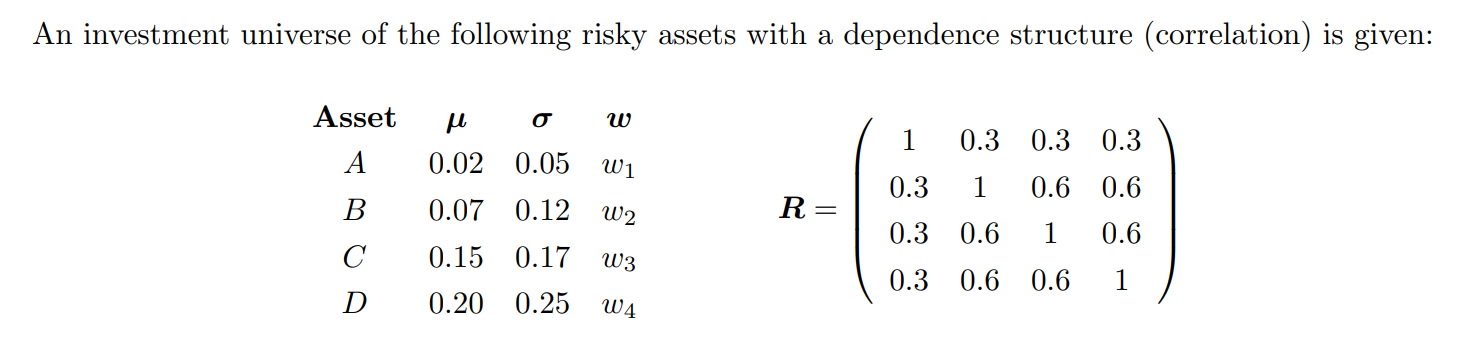

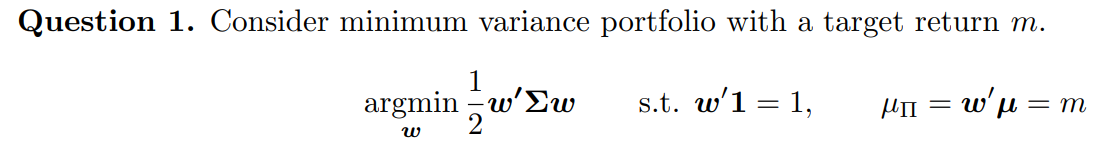

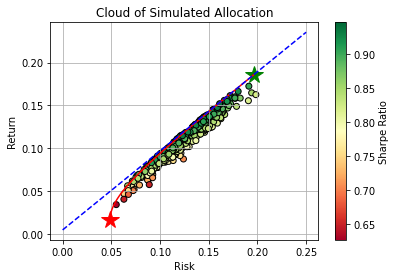

In [153]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0) ##set random seed

class Portfolio():
    
    def __init__(self,u,std,R):
        self.u=u     ##given risky asset return
        self.std=std ##given risky asset std
        self.R=R     ##given risky asset correlation matrix
        
        self.dim=R.shape[0]  ##risky assets num
        self.unit=np.ones(self.dim) ## unit vect
        self.S=np.diag(std)  ##diagnoal matrix
        self.sigma=self.S.T.dot(self.R).dot(self.S)  ##sigma matrix
        self.inv_sigma=np.linalg.inv(self.sigma) ##inverse sigma matrix
        
        self.A=self.unit.T.dot(np.linalg.inv(self.sigma)).dot(self.unit)
        self.B=self.u.T.dot(np.linalg.inv(self.sigma)).dot(self.unit)
        self.C=self.u.T.dot(np.linalg.inv(self.sigma)).dot(self.u)        
    
    def generate_samples(self,N=700): ##N->number of samples
        ws=[np.random.random(self.dim) for _ in range(N)]  ##N random allocations
        ws_norm=list(map(lambda w:w/sum(w),ws))  ##Standardise weights which satisfy sum(w) = 1
        u_port_list=list(map(lambda w:w.T.dot(self.u),ws_norm)) 
        std_port_list=list(map(lambda w:np.sqrt(w.T.dot(self.sigma).dot(w)),ws_norm)) 
        return std_port_list, u_port_list
    
    def get_EF_points(self, m, r=None): ##m->given portfolio return  r->risk free rate
        if not r: ##risky assets only
            w_star=1/(self.A*self.C-self.B**2)*self.inv_sigma.dot((self.A*self.u-self.B*self.unit)*m+(self.C*self.unit-self.B*self.u))
        else:     ##with risk-free asset
            numerator=(m-r)*self.inv_sigma.dot(self.u-r*self.unit) 
            denominator=(self.u-r*self.unit).dot(self.inv_sigma).dot(self.u-r*self.unit) 
            w_star=numerator/denominator
        std_port=np.sqrt(w_star.T.dot(self.sigma).dot(w_star))
        u_port=w_star.T.dot(self.u)
        return w_star, std_port, u_port

    def get_CML(self, r, wt_std_port, wt_u_port):
        slope=(wt_u_port-r)/wt_std_port
        intercept=r
        return slope, intercept

    def get_min_var_portfolio(self): 
        w_g=self.inv_sigma.dot(self.unit)/self.A
        wg_std_port=np.sqrt(w_g.T.dot(self.sigma).dot(w_g))
        wg_u_port=w_g.T.dot(self.u)
        return w_g, wg_std_port, wg_u_port    

    def get_tangency_portfolio(self,r=None): ##r->risk free rate 
        w_t=self.inv_sigma.dot(self.u-r*self.unit)/(self.B-self.A*r)
        wt_std_port=np.sqrt(w_t.T.dot(self.sigma).dot(w_t))
        wt_u_port=w_t.T.dot(self.u)
        return w_t, wt_std_port, wt_u_port      
    
    def plot(self,r, std_port_list, u_port_list, 
                  wg_std_port, wg_u_port,
                  wt_std_port, wt_u_port):
        u_list1 = list(np.linspace(wg_u_port, wt_u_port, 100))
        std_list1=[self.get_EF_points(u)[1] for u in u_list1]
        
        slope, intercept=self.get_CML(r, wt_std_port, wt_u_port)
        std_list2 = list(np.linspace(0, 0.25, 100))
        u_list2=[std*slope+intercept for std in std_list2]        
        
        plt.colorbar(plt.scatter(std_port_list, u_port_list, c=np.array(u_port_list) / np.array(std_port_list), 
                                marker='o', cmap='RdYlGn', edgecolors='black'), label='Sharpe Ratio') 
        plt.plot(wg_std_port, wg_u_port, 'r*', markersize=18)
        plt.plot(wt_std_port, wt_u_port, 'g*', markersize=18)
        plt.plot(std_list1, u_list1, 'r-')
        plt.plot(std_list2, u_list2, 'b--')
        #plt.xlim(0, 0.25)
        #plt.ylim(0, 0.25)
        plt.title('Cloud of Simulated Allocation')
        plt.xlabel('Risk')
        plt.ylabel('Return')
        plt.grid('True')
    
  

if __name__=='__main__':
    r=0.005
    u=np.array([0.02,0.07,0.15,0.2])
    std=np.array([0.05,0.12,0.17,0.25])
    R=np.array([[1.0, 0.3 ,0.3 ,0.3],
                [0.3 ,1.0, 0.6, 0.6],
                [0.3, 0.6 ,1.0 ,0.6],
                [0.3, 0.6, 0.6, 1.0]])

    portfolio=Portfolio(u=u,std=std,R=R)
    w_g, wg_std_port, wg_u_port=portfolio.get_min_var_portfolio()
    # w_star, std_port, u_port=portfolio.get_EF_points(m=0.1,r=0.025)
    w_t, wt_std_port, wt_u_port=portfolio.get_tangency_portfolio(r=r)
    std_port_list, u_port_list=portfolio.generate_samples(N=700)
    portfolio.plot(r=r, std_port_list=std_port_list,u_port_list=u_port_list,
                   wg_std_port=wg_std_port,wg_u_port=wg_u_port,
                   wt_std_port=wt_std_port, wt_u_port=wt_u_port)

Formulate the Lagrangian and give its partial derivatives.
$$
\begin{aligned}
& \Large L(w,\lambda, \gamma)=\frac{1}{2}w^T \Sigma w + \lambda (m- w^Tu) + \gamma (1_{N}-w^T 1_{N}) \\
& \Large \frac{\partial L}{\partial w}(w,\lambda, \gamma)=\Sigma w - \lambda u - \gamma 1_{N}
\end{aligned}
$$

Write down the analytical solution for optimal allocations w∗
(derivation not required).
$$
\begin{aligned}
& \Large A=1_{N}^T \Sigma ^{-1} 1_{N} \\
& \Large B=u^T \Sigma ^{-1} 1_{N} = 1_{N}^T \Sigma ^{-1} u \\
& \Large C=u^T \Sigma ^{-1} u \\
& \Large m=\frac{B}{A} \\
\end{aligned}
$$

$$
\begin{aligned}
\Large w^* &=\frac{1}{AC-B^2} \Sigma ^{-1} [(Au-B 1_{N})m+(C 1_{N}-Bu)] \\
&=\frac{\Sigma ^{-1}1_{N}}{A} \\
&=[ 0.9426708 ,  0.11195005, -0.00606273, -0.04855812]
\end{aligned}
$$

In [154]:
w_g, wg_std_port, wg_u_port=portfolio.get_min_var_portfolio()
w_g

array([ 0.9426708 ,  0.11195005, -0.00606273, -0.04855812])

Inverse optimisation: generate above 700 random allocation sets (vectors) 4 × 1, those will not be
optimal allocations.

In [155]:
ws=[np.random.random(portfolio.dim) for _ in range(700)]  ##N random allocations
ws[:5]

[array([0.4343299 , 0.27846896, 0.00505187, 0.18630352]),
 array([0.97986412, 0.86728608, 0.26650464, 0.96374886]),
 array([0.36771262, 0.29758537, 0.15280764, 0.90161107]),
 array([0.98699249, 0.3274114 , 0.70343042, 0.33530341]),
 array([0.10499074, 0.39269231, 0.55156996, 0.12301676])]

Standardise each set to satisfy $w^T 1_{N}$ = 1, in fact you can generate 3 allocations and compute the 4th.

In [156]:
ws_norm=list(map(lambda w:w/sum(w),ws))       ##700 random allocation sets which  satisfy w1 = 1
ws_norm[:5]

[array([0.48037147, 0.30798833, 0.0055874 , 0.2060528 ]),
 array([0.3184061 , 0.28182395, 0.08660048, 0.31316946]),
 array([0.21382162, 0.17304326, 0.08885628, 0.52427884]),
 array([0.41943677, 0.13913822, 0.29893296, 0.14249205]),
 array([0.08956193, 0.33498459, 0.47051453, 0.10493895])]

For each vector of allocations compute $u_{\pi}=w^T u$ and $\sigma_{\pi}=\sqrt{w^T \Sigma w}$

In [157]:
u_port=list(map(lambda w:w.T.dot(portfolio.u),ws_norm)) 
std_port=list(map(lambda w:np.sqrt(w.T.dot(portfolio.sigma).dot(w)),ws_norm)) 
u_port[:5], std_port[:5]

([0.07321528277805658,
  0.10171976327866464,
  0.13457367039271026,
  0.09146676413510851,
  0.1168051298208555],
 [0.09094767779045308,
  0.1187984271296542,
  0.15824693249693272,
  0.09885459998650248,
  0.12945144352949503])

Plot the cloud of points of $u_{\pi}$ vertically on $\sigma_{\pi}$ horizontally. Explain this plot.

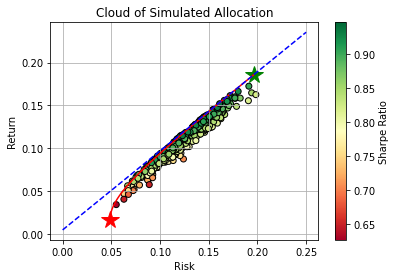

In [158]:
portfolio.plot(r=r, std_port_list=std_port_list,u_port_list=u_port_list,
               wg_std_port=wg_std_port,wg_u_port=wg_u_port,
               wt_std_port=wt_std_port, wt_u_port=wt_u_port)

Explain this plot:  
1.The diagram above includes 700 points of portfolio-return vertically on portfolio-risk horizontally.  
2.Each weight vector is uniform sampling between [0,1] and sum of vector equals to 1.  
3.The dash blue line and red line represent the CML and EF respectively.  
4.The color of point represent the sharp-ratio.  
5.The green star and red star represent the tengency and min_var point respectively.  
6.As we vary weight vector, so the Risk and the Return change. The cloud points of risk/return space
parameterized by weight vector is nearly a straight line because correlation among risky assets are relatively large. The top edge of this cloud with deep green color are more efficient and preferable than rest of allocations

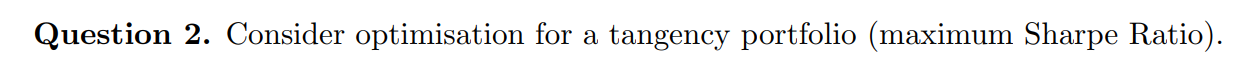

Formulate optimisation expression.
$$
\Large min_{w} \quad \frac{1}{2}w^T \Sigma w \quad st.\quad r+w^{T}(u-r 1_{N})=m
$$

Formulate Lagrangian function and give its partial derivatives only.
$$
\begin{aligned}
& \Large L(w,\lambda)=\frac{1}{2}w^T \Sigma w + \lambda (m-r-w^T(u-r1_{N})) \\
& \Large \frac{\partial L}{\partial w}(w,\lambda)=\Sigma w - \lambda (u - \gamma 1_{N})
\end{aligned}
$$

For the range of tangency portfolios given by rf = 50bps, 100bps, 150bps, 175bps optimal compute
allocations (ready formula) and σΠ. Present results in a table

In [159]:
df=pd.DataFrame()
df.index=['r50','r100','r150','r175']
w_t_list=[]
u_t_list=[]
std_t_list=[]
for r in [0.005,0.01,0.015,0.0175]:
    w_t, wt_std_port, wt_u_port = portfolio.get_tangency_portfolio(r=r)
    w_t_list.append(str(w_t))
    u_t_list.append(wt_u_port)
    std_t_list.append(wt_std_port)
df['optimal weights']=w_t_list
df['return_portfolio']=u_t_list
df['risk_portfolio']=std_t_list
df

,optimal weights,return_portfolio,risk_portfolio
r50,[ 0.0168352 -0.22936698 0.81434026 0.39819152],0.186070,0.196511
r100,[-0.74593711 -0.51056937 1.49024934 0.76625714],0.326130,0.350665
r150,[-8.64485405 -3.42257114 8.48965087 4.57777433],1.776525,1.972392
r175,[ 8.10350247 2.75185052 -6.3514309 -3.50392209],-1.298799,1.473515


Plot the efficient frontier in the presence of a risk-free asset for rf = 100bps, 175bps

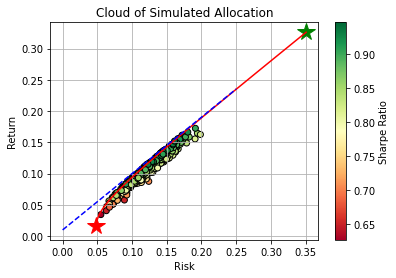

In [160]:
w_t, wt_std_port, wt_u_port=portfolio.get_tangency_portfolio(r=0.01)
portfolio.plot(r=0.01, std_port_list=std_port_list,u_port_list=u_port_list,
               wg_std_port=wg_std_port,wg_u_port=wg_u_port,
               wt_std_port=wt_std_port, wt_u_port=wt_u_port)

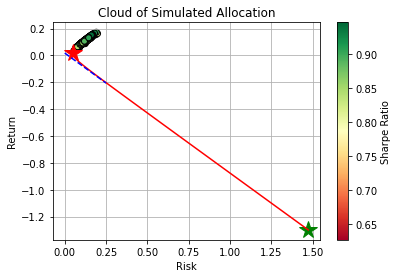

In [161]:
w_t, wt_std_port, wt_u_port=portfolio.get_tangency_portfolio(r=0.0175)
portfolio.plot(r=0.0175, std_port_list=std_port_list,u_port_list=u_port_list,
               wg_std_port=wg_std_port,wg_u_port=wg_u_port,
               wt_std_port=wt_std_port, wt_u_port=wt_u_port)